In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMRegressor
from IPython.display import display
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

df = pd.read_csv("Sleep_health_and_lifestyle_dataset.csv")


In [2]:
# blood pressure
df[['Systolic_BP', 'Diastolic_BP']] = df['Blood Pressure'].str.split('/', expand=True)
df['Systolic_BP'] = pd.to_numeric(df['Systolic_BP'], errors='coerce')
df['Diastolic_BP'] = pd.to_numeric(df['Diastolic_BP'], errors='coerce')
df.drop(columns=['Blood Pressure'], inplace=True)

# Feature Engineering - Generating Mean_BP, solving multicollinearity problem
df["Mean_BP"] = (df["Systolic_BP"] + df["Diastolic_BP"]) / 2
df.drop(columns=["Systolic_BP", "Diastolic_BP"], inplace=True)

# feature selection
features = ['Sleep Duration', 'Physical Activity Level', 'Stress Level',
            'Heart Rate', 'Daily Steps', 'Mean_BP']
target = 'Quality of Sleep'

df[features] = df[features].fillna(df[features].mean())
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=0)

# setting model
models = {
    "MLP Regressor": MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', max_iter=500, random_state=0),
    "LightGBM": LGBMRegressor(min_data_in_leaf=10, num_leaves=31, n_estimators=200, learning_rate=0.05, random_state=0, verbose=-1),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=0)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {"MSE": mse, "MAE": mae, "R² Score": r2}

results_df = pd.DataFrame(results).T
display(results_df)


,MSE,MAE,R² Score
MLP Regressor,0.069053,0.133973,0.946247
LightGBM,0.031174,0.069249,0.975733
Random Forest,0.028136,0.044952,0.978098


In [3]:
#Select the Random Forest

# get parameter's search grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt']
}

rf = RandomForestRegressor(random_state=42)

# GridSearchCV
grid_search = GridSearchCV(
    estimator=rf, param_grid=param_grid,
    cv=5, scoring='neg_mean_squared_error', n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [5]:
# Learn Random Forest model with optimal hyperparameters
best_params = grid_search.best_params_

best_rf = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features=best_params['max_features'],
    random_state=42
)

best_rf.fit(X_train, y_train)

y_pred = best_rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Final Optimized Random Forest Model Performance:")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# compare with previous models
results = {
    "Model": ["Optimized Random Forest", "MLP Regressor", "LightGBM"],
    "MSE": [mse, 0.069053, 0.031174],  
    "MAE": [mae, 0.133973, 0.069249],
    "R² Score": [r2, 0.946247, 0.975733]
}

results_df = pd.DataFrame(results)


Final Optimized Random Forest Model Performance:
✅ MSE: 0.0204
✅ MAE: 0.0490
✅ R² Score: 0.9841


In [7]:
display(results_df)

,Model,MSE,MAE,R² Score
0,Optimized Random Forest,0.020429,0.049011,0.984097
1,MLP Regressor,0.069053,0.133973,0.946247
2,LightGBM,0.031174,0.069249,0.975733


/var/folders/d5/v0w7v20x70z55jvhywdpp06h0000gn/T/ipykernel_83492/3348350778.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='Blues_r')


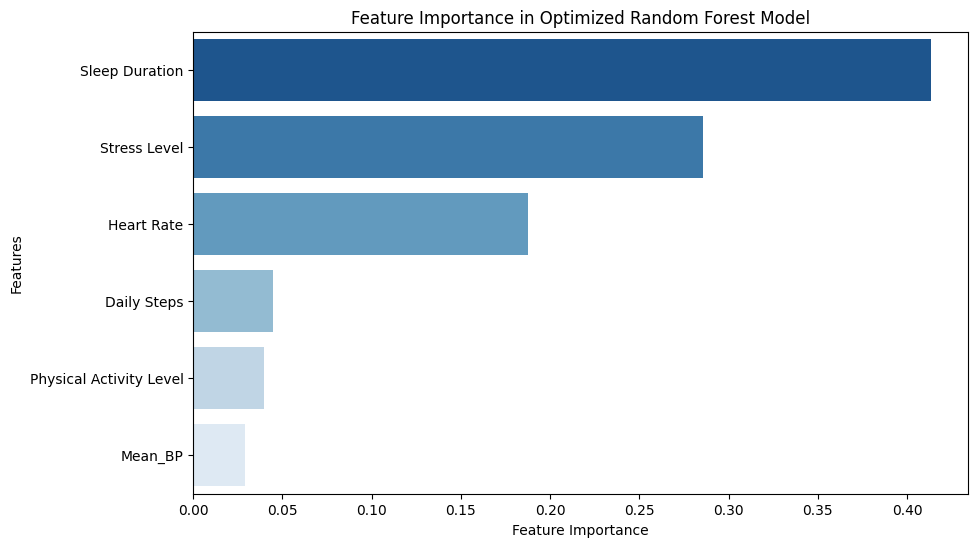

In [8]:
# Feature Importance
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': best_rf.feature_importances_})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='Blues_r')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in Optimized Random Forest Model")
plt.show()